In [ ]:
#| default_exp sql

# Sql

> A query plus a database connection.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore.test import *
from fastcore.utils import *
import numpy as np
import psycopg2
import pandas as pd

from sqlviz.parser import *
from sqlviz.utils import *

In [ ]:
#| export
class Conn:
    
    "A wrapper around a psycopg2 connection."
    
    def __init__(self, creds:dict):
        self.conn = psycopg2.connect(**creds)
        self.curs = self.conn.cursor()

In [ ]:
#| export
@patch
def run_query(self:Conn,
              query:str,
             ) -> Union[str, pd.DataFrame]:

    "Run a query and return a Dataframe or an error string."
    
    try:
        self.curs.execute(query)
    except psycopg2.Error as e:
        self.conn.rollback()
        return e.pgerror
    else:
        rows = self.curs.fetchall()
        rows = [[str(v) for v in row] for row in rows]
        cols = list(zip(*rows))
        names = [d[0] for d in self.curs.description]
        return pd.DataFrame({n : list(c) for n, c in zip(names, cols)})

In [ ]:
conn = Conn(CREDS)
conn.run_query(Q[1])

,email,url
0,sk.bhachech@everbridge.com,https://everbridge.zengrc.com/reports/audits/a...
1,sk.bhachech@everbridge.com,https://everbridge.zengrc.com/sor/listing/Revi...
2,maria_sonina@colpal.com,https://colgate.zengrc.com/sor/info/Project/22...
3,chuck.walkup@virginpulse.com,https://virginpulse.zengrc.com/todo_list/To-Do...
4,chuck.walkup@virginpulse.com,https://virginpulse.zengrc.com/sor/listing/Iss...


In [ ]:
#| export
class Sql:
    
    "A query plus a db connection."
    
    def __init__(self, conn:Conn, query:str):
        self.conn = conn
        self.query = query
        self.parsed = parse_operations(query)
        self.res = None
        
    def run(self):
        "Run a query."
        self.res = self.conn.run_query(self.query)
        return self.res

In [ ]:
Sql(conn, Q[1]).parsed

{'limit': '5',
 'from': 'pageviews',
 'select': ['email', 'url'],
 '_ops': ['limit', 'from', 'select']}

In [ ]:
Sql(conn, Q[1]).run()

,email,url
0,sk.bhachech@everbridge.com,https://everbridge.zengrc.com/reports/audits/a...
1,sk.bhachech@everbridge.com,https://everbridge.zengrc.com/sor/listing/Revi...
2,maria_sonina@colpal.com,https://colgate.zengrc.com/sor/info/Project/22...
3,chuck.walkup@virginpulse.com,https://virginpulse.zengrc.com/todo_list/To-Do...
4,chuck.walkup@virginpulse.com,https://virginpulse.zengrc.com/sor/listing/Iss...


## viz_from

In [ ]:
#| export
@patch
def get_nrows(self:Sql, table:str):
    q = "SELECT count(*) from " + table
    df = self.conn.run_query(q)
    return int(df.iloc[0,0])

@patch
def get_ncols(self:Sql, table:str):
    ncols_query = "SELECT * from " + table + " LIMIT 1"
    ncols_df = self.conn.run_query(ncols_query)
    return ncols_df.shape[1]

@patch
def get_table_hw(self:Sql, table:str):
    return self.get_nrows(table), self.get_ncols(table)

@patch
def viz_from(self:Sql) -> np.array:
    hw = self.get_table_hw(self.parsed['from'])
    return rect(hw, 'green')

In [ ]:
array = Sql(conn, Q[3]).viz_from()

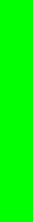

In [ ]:
to_img(array, 8)

In [ ]:
#| export
@patch
def viz_where(self:Sql):
    
    t_color, f_color = colors['green'], colors['lightgrey']
    
    where_query = f"""
      select
        case when {self.parsed['where']}
             then {t_color}
             else {f_color}
             end as color
      from {self.parsed['from']}
      """
    
    df = Sql(conn, where_query).run()
    df['color'] = df['color'].apply(float)
    
    ncols = self.get_ncols(self.parsed['from'])
    
    res = np.repeat(df.to_numpy(), ncols, axis=1)
    return res

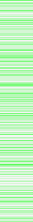

In [ ]:
to_img(Sql(conn, Q[3]).viz_where(), 8)